## What to Watch Next? Build an Interactive Movie Recommender Application using Singular Value Decomposition and Collaborative Filtering

Note: you can install the requirements file for this notebook if you want to install all the libraries at once. Open a new terminal window, navigate to the folder with the "requirements_jupyter.txt" and run the following command:

pip3 install -r requirements_jupyter.txt

In [1]:
# !pip3 install -r requirements_jupyter.txt

## Load ratings dataframe 
Download data:
http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

ratings_df_raw = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df = ratings_df_raw.copy()
print('Shape:', ratings_df.shape)
ratings_df.tail()


Shape: (100004, 4)


,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


Fix timestamp column to be readable datetime 

In [3]:
import datetime
# change timestamp from seconds from Jan 1970 to a readable date time
ratings_df['timestamp'] = [datetime.datetime.fromtimestamp(dt) for dt in ratings_df['timestamp'].values]
ratings_df['timestamp'].describe()


count                  100004
unique                  78141
top       2016-07-23 05:54:42
freq                       87
first     1995-01-09 03:46:49
last      2016-10-16 10:57:24
Name: timestamp, dtype: object

In [4]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [5]:
ratings_df.describe()

,userId,movieId,rating
count,100004.000000,100004.000000,100004.000000
mean,347.011310,12548.664363,3.543608
std,195.163838,26369.198969,1.058064
min,1.000000,1.000000,0.500000
25%,182.000000,1028.000000,3.000000
50%,367.000000,2406.500000,4.000000
75%,520.000000,5418.000000,4.000000
max,671.000000,163949.000000,5.000000


In [6]:
print('Unique number of rated movies: %i' % len(set(ratings_df['movieId'])))

Unique number of rated movies: 9066


In [7]:
print('Unique user count with ratings: %i' % len(set(ratings_df['userId'])))

Unique user count with ratings: 671


## Load movie dataframe 

In [8]:
movies_df_raw = pd.read_csv('ml-latest-small/movies.csv')
movies_df = movies_df_raw.copy()
print('Shape:', movies_df.shape)
movies_df.tail()

Shape: (9125, 3)


,movieId,title,genres
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy
9124,164979,"Women of '69, Unboxed",Documentary


In [9]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


In [10]:
movies_df.describe()

,movieId
count,9125.000000
mean,31123.291836
std,40782.633604
min,1.000000
25%,2850.000000
50%,6290.000000
75%,56274.000000
max,164979.000000


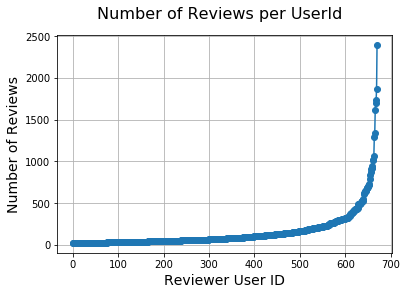

In [11]:
# Top reviewers
plt.plot(sorted(ratings_df['userId'].value_counts(normalize=False)), marker='o')
plt.suptitle('Number of Reviews per UserId', fontsize=16)
plt.xlabel('Reviewer User ID', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.grid()
plt.show()

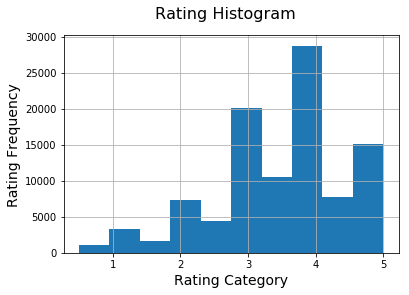

In [12]:
# Rating category sums
ratings_df['rating'].plot.hist()
plt.suptitle('Rating Histogram', fontsize=16)
plt.xlabel('Rating Category', fontsize=14)
plt.ylabel('Rating Frequency', fontsize=14)
plt.grid()
plt.show()

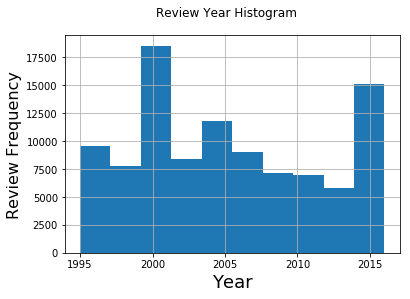

In [13]:
ratings_df['timestamp'].dt.year.plot.hist()
plt.suptitle('Review Year Histogram')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Review Frequency', fontsize=16)
plt.grid()
plt.show()

## Overall Top Movie Genres

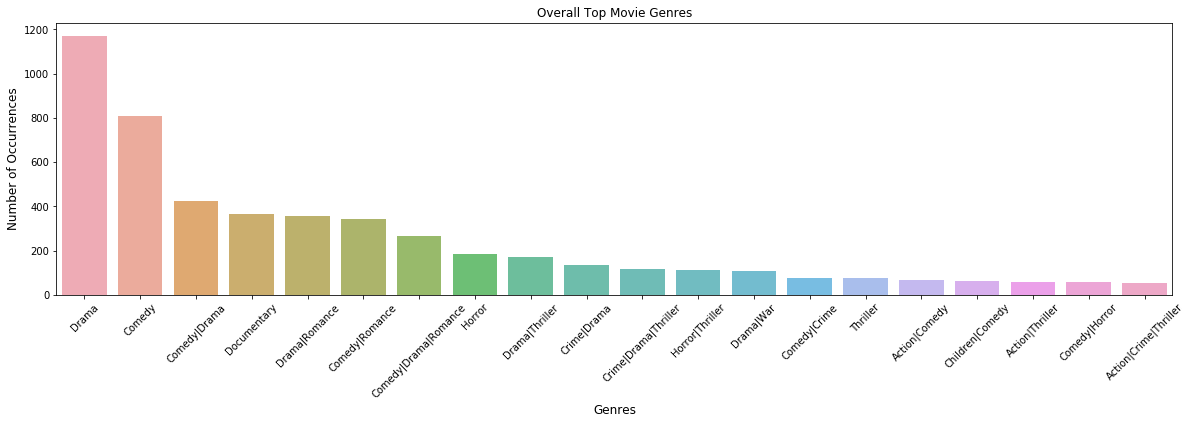

In [14]:
top_genres = movies_df['genres'].value_counts(normalize=False)
top_genres = top_genres[:20,]
plt.figure(figsize=(20,5))
sns.barplot(top_genres.index, top_genres.values, alpha=0.8)
plt.title('Overall Top Movie Genres')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.xticks(rotation=45)
plt.show()
 

## Top Genres Count by Year Reviewed

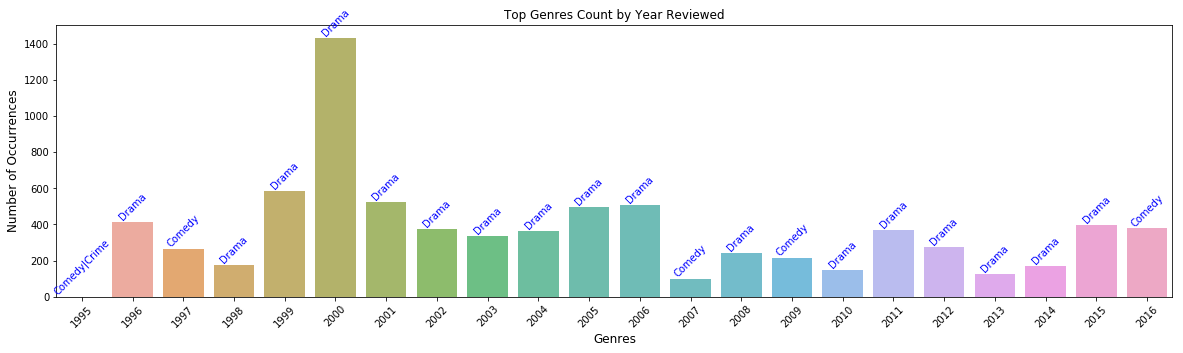

In [15]:
# Top Movie Genres by Year
# Get the user's data and merge in the movie information
reviews_by_genres = pd.merge(movies_df, ratings_df, how = 'inner', on ='movieId') 
reviews_by_genres['year'] = reviews_by_genres['timestamp'].dt.year

def top_category_count(x, n=1):
    return x.value_counts().head(n)

reviews_by_genres = reviews_by_genres.groupby(['year']).genres.apply(top_category_count).reset_index()
reviews_by_genres
 
plt.figure(figsize=(20,5))
g = sns.barplot(reviews_by_genres['year'], reviews_by_genres['genres'], alpha=0.8)
plt.title('Top Genres Count by Year Reviewed')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.xticks(rotation=45)
 
  
for index, row in reviews_by_genres.iterrows():
    g.text(row.name,row.genres, row.level_1, ha="center", rotation=45, color='blue', 
           verticalalignment='bottom', fontsize=10)

plt.show()

## Cleaning up Ratings and Movies

In [16]:
# fix all userIds and movieIds
movies_df_raw = pd.read_csv('ml-latest-small/movies.csv')

# remove timestamp from original ratings_df_raw
ratings_df_raw = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df_raw = ratings_df_raw[['userId', 'movieId', 'rating']]

# remove any movies not found in the ratings set
movies_df_raw = movies_df_raw[movies_df_raw['movieId'].isin(ratings_df_raw['movieId'])]
movies_df_raw.tail()

movies_df_raw = movies_df_raw.reset_index(drop=True)
movies_df_raw['movieId_new'] = movies_df_raw.index
movies_df_raw.tail()

,movieId,title,genres,movieId_new
9061,161944,The Last Brickmaker in America (2001),Drama,9061
9062,162376,Stranger Things,Drama,9062
9063,162542,Rustom (2016),Romance|Thriller,9063
9064,162672,Mohenjo Daro (2016),Adventure|Drama|Romance,9064
9065,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary,9065


In [17]:

# make all ratings movieIds the same
ratings_df_raw = ratings_df_raw.merge(movies_df_raw[['movieId', 'movieId_new']], on='movieId', how='inner') 
ratings_df_raw = ratings_df_raw[['userId',  'movieId_new', 'rating']]
ratings_df_raw.columns = ['userId',  'movieId', 'rating']

# clean up userids to start at 0 not 1
ratings_df_raw['userId'] -= 1
ratings_df = ratings_df_raw.copy()
ratings_df.head()


,userId,movieId,rating
0,0,30,2.5
1,6,30,3.0
2,30,30,4.0
3,31,30,4.0
4,35,30,3.0


In [18]:

movies_df_raw = movies_df_raw[['movieId_new', 'title', 'genres']]
movies_df_raw.columns = ['movieId', 'title', 'genres']
movies_df = movies_df_raw.copy()
movies_df.tail()


,movieId,title,genres
9061,9061,The Last Brickmaker in America (2001),Drama
9062,9062,Stranger Things,Drama
9063,9063,Rustom (2016),Romance|Thriller
9064,9064,Mohenjo Daro (2016),Adventure|Drama|Romance
9065,9065,The Beatles: Eight Days a Week - The Touring Y...,Documentary


## Create genres list

In [19]:
genres = movies_df['genres']
genres = sorted(list(set([y for x in [gn.split('|') for gn in genres] for y in x])))
genres[0] = 'Any genres'
genres

['Any genres',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

## Creating a matrix to quickly get recommendations

In [20]:
import scipy.sparse.linalg
from sklearn.metrics import mean_absolute_error
import scipy.sparse as sps

# set userId and movieId as indexes in order to make them as x and y axis of sparse matrix
ratings_df = ratings_df_raw.copy()
print('unique users:', len(set(ratings_df['userId'])))
print('unique movies:', len(set(ratings_df['movieId'])))

ratings_df.set_index(['userId', 'movieId'], inplace=True)
ratings_matrix = sps.csr_matrix((ratings_df.rating, 
                      (ratings_df.index.labels[0], ratings_df.index.labels[1]))).todense()

print('shape ratings_matrix:', ratings_matrix.shape)


unique users: 671
unique movies: 9066
shape ratings_matrix: (671, 9066)


In [21]:
# set our seed row of ratings using movie Toy Story
movie_toy_story = (ratings_matrix[:,0])
movie_toy_story[0:20]

matrix([[0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [3. ],
        [0. ],
        [4. ],
        [0. ],
        [0. ],
        [0. ],
        [5. ],
        [0. ],
        [2. ],
        [0. ],
        [0. ],
        [0. ],
        [3. ],
        [3.5]])

 ## Euclidean Distance

In [22]:

distances_to_movie = []
for other_movies in ratings_matrix.T:
    distances_to_movie.append(scipy.spatial.distance.euclidean(movie_toy_story, other_movies.tolist()))
     
# create dataframe of movie and distance scores to Toy Story 
distances_to_movie = pd.DataFrame({'movie':movies_df['title'],'distance':distances_to_movie})

# sort by ascending distance (i.e. closest to movie_toy_story)
distances_to_movie = distances_to_movie.sort_values('distance')
distances_to_movie.head(10)

,movie,distance
0,Toy Story (1995),0.000000
2506,Toy Story 2 (1999),50.882217
1866,"Bug's Life, A (1998)",53.849327
1019,Groundhog Day (1993),54.904462
644,Independence Day (a.k.a. ID4) (1996),55.009090
3803,"Monsters, Inc. (2001)",55.056789
4604,Finding Nemo (2003),55.522518
5611,"Incredibles, The (2004)",55.709066
3419,Shrek (2001),56.333826
866,Willy Wonka & the Chocolate Factory (1971),56.643623


## Manhattan Distance

In [23]:
distances_to_movie = []
for other_movies in ratings_matrix.T:
    distances_to_movie.append(scipy.spatial.distance.cityblock(movie_toy_story, other_movies.tolist()))
     
# create dataframe of movie and distance scores to Toy Story 
distances_to_movie = pd.DataFrame({'movie':movies_df['title'],'distance':distances_to_movie})

# sort by ascending distance - i.e. closest to movie_toy_story
distances_to_movie = distances_to_movie.sort_values('distance')
distances_to_movie.head(10)

,movie,distance
0,Toy Story (1995),0.0
2506,Toy Story 2 (1999),676.0
1866,"Bug's Life, A (1998)",764.5
3803,"Monsters, Inc. (2001)",783.5
4604,Finding Nemo (2003),792.5
1019,Groundhog Day (1993),798.0
5611,"Incredibles, The (2004)",800.0
3419,Shrek (2001),814.0
866,Willy Wonka & the Chocolate Factory (1971),825.0
644,Independence Day (a.k.a. ID4) (1996),826.0


## Jaccard distance

In [24]:
distances_to_movie = []
for other_movies in ratings_matrix.T:
    distances_to_movie.append(scipy.spatial.distance.jaccard(movie_toy_story, other_movies.tolist()))
     
# create dataframe of movie and distance scores to Toy Story 
distances_to_movie = pd.DataFrame({'movie':movies_df['title'],'distance':distances_to_movie})

# sort by ascending distance (i.e. closest to movie_toy_story)
distances_to_movie = distances_to_movie.sort_values('distance')
distances_to_movie.head(10)

,movie,distance
0,Toy Story (1995),0.000000
2506,Toy Story 2 (1999),0.800738
232,Star Wars: Episode IV - A New Hope (1977),0.858289
955,Raiders of the Lost Ark (Indiana Jones and the...,0.860058
1024,Back to the Future (1985),0.870206
328,"Lion King, The (1994)",0.872727
866,Willy Wonka & the Chocolate Factory (1971),0.874576
966,Star Wars: Episode VI - Return of the Jedi (1983),0.875371
3419,Shrek (2001),0.875817
427,Jurassic Park (1993),0.877005


## Cosine distance

In [25]:
distances_to_movie = []
for other_movies in ratings_matrix.T:
    distances_to_movie.append(scipy.spatial.distance.cosine(movie_toy_story, other_movies.tolist()))
     
# create dataframe of movie and distance scores to Toy Story 
distances_to_movie = pd.DataFrame({'movie':movies_df['title'],'distance':distances_to_movie})

# sort by ascending distance (i.e. closest to movie_toy_story)
distances_to_movie = distances_to_movie.sort_values('distance')
distances_to_movie.head(10)

,movie,distance
0,Toy Story (1995),0.000000
2506,Toy Story 2 (1999),0.405290
232,Star Wars: Episode IV - A New Hope (1977),0.423812
321,Forrest Gump (1994),0.435466
644,Independence Day (a.k.a. ID4) (1996),0.437054
1019,Groundhog Day (1993),0.451977
1024,Back to the Future (1985),0.463300
427,Jurassic Park (1993),0.464803
3419,Shrek (2001),0.467315
966,Star Wars: Episode VI - Return of the Jedi (1983),0.470666


## Singular Value Decomposition (SVD) 

In [26]:

def GetSparseSVD(ratings_centered_matrix, K):
    '''
    # Compute the largest k singular values/vectors for a sparse matrix.
    # k : int, optional
    # Number of singular values and vectors to compute. Must be 1 <= k < min(A.shape)
    
    Returns
    u : ndarray, shape=(M, k) Unitary matrix having left singular vectors as columns 
    sigma : ndarray, shape=(k,k) Diagonal singular values.
    vt : ndarray, shape=(k, N)Unitary matrix having right singular vectors as rows
    '''

    u, s, vt = svds(ratings_centered_matrix, k=K)
    # get it back in k diagongal format for matrix multiplication
    sigma = np.diag(s)
    return u, sigma, vt
    


## Pull out all movie genres for testing

In [27]:
# get movies by genre
top_genres = movies_df['genres'].value_counts(normalize=False)
top_genres = top_genres[:20,]
print('top_genres: ', top_genres)


top_genres:  Drama                    1156
Comedy                    804
Comedy|Drama              424
Documentary               359
Drama|Romance             354
Comedy|Romance            341
Comedy|Drama|Romance      264
Horror                    182
Drama|Thriller            170
Crime|Drama               134
Crime|Drama|Thriller      115
Horror|Thriller           111
Drama|War                 107
Comedy|Crime               77
Thriller                   74
Action|Comedy              67
Children|Comedy            64
Action|Thriller            57
Comedy|Horror              57
Action|Crime|Thriller      53
Name: genres, dtype: int64


In [28]:

# get selection of movies for a particular genre to test out SVD model
movies_df[movies_df['genres']== 'Drama|War'][['movieId', 'title']].head(40)

,movieId,title
39,39,Richard III (1995)
68,68,"Misérables, Les (1995)"
188,188,Before the Rain (Pred dozhdot) (1994)
301,301,"Walking Dead, The (1995)"
472,472,Schindler's List (1993)
553,553,Land and Freedom (Tierra y libertad) (1995)
633,633,Stalingrad (1993)
784,784,A Walk in the Sun (1945)
881,881,Platoon (1986)
922,922,"Tin Drum, The (Blechtrommel, Die) (1979)"


## Our fictional user's movie preferences

In [29]:
user_history_movie_ids_fake = [301, 472, 188]
movies_df[movies_df['movieId'].isin([301, 472, 188])]

,movieId,title,genres
188,188,Before the Rain (Pred dozhdot) (1994),Drama|War
301,301,"Walking Dead, The (1995)",Drama|War
472,472,Schindler's List (1993),Drama|War


# Let's abstract out our functions for the web appliction

In [30]:
MOVIE_GENRES = ["Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
                "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                "IMAX", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller",
                "War", "Western"]

ratings_df
movies_df
from scipy.sparse.linalg import svds

def startup():
    global ratings_df, movies_df
    # load data sets
    # fix all userIds and movieIds
    movies_df_raw = pd.read_csv('ml-latest-small/movies.csv')
    # movies_df_raw['movieId_new'] = movies_df_raw.index

    # remove timestamp from original ratings_df_raw
    ratings_df_raw = pd.read_csv('ml-latest-small/ratings.csv')
    ratings_df_raw = ratings_df_raw[['userId', 'movieId', 'rating']]

    # remove any movies not found in the ratings set
    movies_df_raw = movies_df_raw[movies_df_raw['movieId'].isin(ratings_df_raw['movieId'])]

    # reset index
    movies_df_raw = movies_df_raw.reset_index(drop=True)
    movies_df_raw['movieId_new'] = movies_df_raw.index

    # make all ratings movieIds the same
    ratings_df_raw = ratings_df_raw.merge(movies_df_raw[['movieId', 'movieId_new']], on='movieId', how='inner') 
    ratings_df_raw = ratings_df_raw[['userId',  'movieId_new', 'rating']]
    ratings_df_raw.columns = ['userId',  'movieId', 'rating']
    # clean up userids to start at 0 not 1
    ratings_df_raw['userId'] -= 1

    movies_df_raw = movies_df_raw[['movieId_new', 'title', 'genres']]
    movies_df_raw.columns = ['movieId', 'title', 'genres']
    movies_df = movies_df_raw.copy()

    # set userId and movieId as indexes in order to make them as x and y axis of sparse matrix
    ratings_df = ratings_df_raw.copy()
    
def GetMoviesByGenres(movies_df, genre):
    # Returns a list of all movies and movie IDs for a particular genre. 
    # It is called whenever a user changes the "Movie Genre" drop-down box
    
    movies_of_type = movies_df[movies_df['genres'].str.contains(genre)].sort_values('title')
    movie_ids = list(movies_of_type['movieId'].values)
    movie_titles = [x[0:50] for x in list(movies_of_type['title'].values)]

    return (movie_ids, movie_titles)

def GetRecommendedMovies(ratings_df, movies_df, user_history_movie_ids):
    # based on https://beckernick.github.io/matrix-factorization-recommender/
    # add back to ratings_matrix_centered
    ratings_df_cp = ratings_df.copy()

    # create a new user id - add 1 to current largest
    new_user_id = np.max(ratings_df_cp['userId']) + 1

    new_user_movie_ids = user_history_movie_ids
    new_user_ratings = 	[4.5] * len(new_user_movie_ids)

    # fix index to be multilevel with userId and movieId
    ratings_df_cp.set_index(['userId', 'movieId'], inplace=True)

    for idx in range(len(new_user_movie_ids)):
        # add new movie rating as a pandas series and insert new row at end of ratings_df_cp
        row_to_append = pd.Series([new_user_ratings[idx]])
        cols = ['rating']
        ratings_df_cp.loc[(new_user_id, new_user_movie_ids[idx]), cols] = row_to_append.values

    # create new ratings_matrix
    ratings_matrix_plus = sps.csr_matrix((ratings_df_cp.rating, 
                          (ratings_df_cp.index.labels[0], ratings_df_cp.index.labels[1]))).todense()

    user_ratings_mean = np.mean(ratings_matrix_plus, axis = 1)
    ratings_matrix_centered = ratings_matrix_plus - user_ratings_mean.reshape(-1, 1)

    Ua, sigma, Vt = GetSparseSVD(ratings_matrix_centered, K=50)
    all_user_predicted_ratings = np.dot(np.dot(Ua, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    # predictions_df based on row/col ids, not original movie ids
    predictions_df = pd.DataFrame(all_user_predicted_ratings, columns = movies_df.index)  

    # Get and sort the user's predictions
    sorted_user_predictions = predictions_df.iloc[new_user_id].sort_values(ascending=False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions.columns = ['movieId', 'predictions']
    sorted_user_predictions = sorted_user_predictions.merge(movies_df, left_on='movieId', 
                        right_on='movieId', how='inner').sort_values('predictions', ascending=False)
    sorted_user_predictions = sorted_user_predictions[~sorted_user_predictions['movieId'].isin(new_user_movie_ids)]
    movie_titles = [x[0:50] for x in list(sorted_user_predictions['title'].values)][0:3]
    return(movie_titles[0], movie_titles[1], movie_titles[2])
 
# testing 
startup()
print('Recomended movies:', GetRecommendedMovies(ratings_df, movies_df, user_history_movie_ids_fake))
        

Recomended movies: ('Forrest Gump (1994)', 'Saving Private Ryan (1998)', 'Shawshank Redemption, The (1994)')


In [31]:
ratings_df.head()

,userId,movieId,rating
0,0,30,2.5
1,6,30,3.0
2,30,30,4.0
3,31,30,4.0
4,35,30,3.0
